In [1]:
%matplotlib inline

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

# Macrostate distribution extrapolation

This notebook demonstrates how to perform temperature extrapolation (or interpolation) of macrostate log-probability distributions $\ln \Pi (N)$ for the number of particles from a flat-histogrammed grand canonical ensemble simulation.

We start by setting up functions to load in the data.

In [2]:
import json

def sample_data():

    with open('../tests/lnpi_data/sample_data.json', 'r') as f:
        d = json.load(f)

    ref, samples = d['ref'], d['samples']
#    return ref, samples
    for x in [ref] + samples:
        # cleanup data
        x['lnPi'] = np.array(x['lnPi'])
        x['energy'] = np.array(x['energy'])


    return ref, samples


def prepare_data(lnPi, energy, mu, temp, order, beta):
    beta = 1.0 / temp
    mu = xr.DataArray(np.atleast_1d(mu), dims=['comp'])
    
    lnPi = xr.DataArray(lnPi, dims=['n'])
    
    # adjust lnPi to have lnPi[n=0] = 0
    lnPi = lnPi - lnPi.sel(n=0)

    # have to include mom = 0
    a = np.ones_like(lnPi)
    energy = np.concatenate((a[:, None], energy), axis=-1)
    energy = xr.DataArray(energy, dims=['n','umom'])
    
    return {'lnPi': lnPi, 'energy': energy, 'mu': mu, 'beta': beta, 'order': order, 'temp': temp}


And actually load in the data to use for extrapolation

In [3]:
ref, samples = sample_data()

ref = prepare_data(**ref)
samples = [prepare_data(**d) for d in samples]

#Sort by temperature for later
betas = np.array([x['beta'] for x in samples])
temps = 1.0/betas #Really will be reduced temperatures
sort_inds = np.argsort(temps)
temps = temps[sort_inds][::2] #Seem to be replicates for each beta?
betas = betas[sort_inds][::2]
samples = [samples[i] for i in sort_inds]
samples = [samples[i] for i in range(0, len(samples), 2)]

We need to import `thermoextrap` generally for access to data classes, then `xpan_lnPi` for special functions related to derivatives of macrostate distributions.

In [5]:
import thermoextrap.xtrapy as xtrapy
import thermoextrap.xtrapy.xpan_lnPi as xpan_lnPi

First, we need to create a data object to hold the data. Selecting the data, however, requires a bit of thought. Though we are interested in extrapolating $\ln \Pi (N)$, it turns out it is more convenient (and equivalent within an additive constant) to extrapolate $\ln \Pi (N) - \ln \Pi (0)$. The first two derivatives of this with respect to $\beta = \frac{1}{k_B T}$ are:

&nbsp;&nbsp;&nbsp;&nbsp;$\frac{\mathrm{d} \ln ( \Pi (N)/\Pi(0) )}{\mathrm{d} \beta} = \mu N - \langle U \rangle_N$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;$\frac{\mathrm{d}^2 \ln ( \Pi (N)/\Pi(0) )}{\mathrm{d} \beta^2} = - \frac{\mathrm{d} \langle U \rangle_N}{\mathrm{d} \beta}$ <br>

The chemical potential is given by $\mu$ and the angle brackets with a subscript of $N$ represent a canonical ensemble average at a particular macrostate with $N$ particles. While the first derivative involves $\mu N$ and the potential energy, it is clear that for $k > 1$,

&nbsp;&nbsp;&nbsp;&nbsp;$\frac{\mathrm{d}^k \ln ( \Pi (N)/\Pi(0) )}{\mathrm{d} \beta^k} = - \frac{\mathrm{d}^{k-1} \langle U \rangle_N}{\mathrm{d} \beta^{k-1}}$

What this means is that all we need is a way to compute canonical ensemble derivatives of an average observable with respect to $\beta$, which we have in `xpan_beta.py`, and a custom derivative function to handle the special case of the 0$^\mathrm{th}$ and 1$^\mathrm{st}$ derivatives. This has been implemented in `xpan_lnpi.py` for convenience.

Based on the discussion above, we start by creating a custom data callback object that helps manage how derivatives are calculated and what information is provided to the function that calculates the derivatives.

In [6]:
# for lnPi extrapolation, we need to setup a DataCallback
# see definition in xpan_lnPi
meta_lnpi = xpan_lnPi.lnPiDataCallback(ref['lnPi'], ref['mu'], dims_n=['n'], dims_comp='comp')

In the above callback, the first argument is the reference $\ln \Pi$ we're extrapolating from, the second argument is the chemical potential $\mu$, `dims_n` is the dimension of the input xarray `DataArray` over which the particle number $N$ changes, and if you really want to understand what `dims_comp` is you'll have to ask Bill.

Next we need a data object to hold the potential energy moments, passing the callback as the `meta` argument. Note that because we're working with potential energies only, we can set `xu=None` and `x_is_u=True` to provide further accelerations for this special case.

In [7]:
data_lnpi = xtrapy.DataCentralMoments.from_ave_raw(u=ref['energy'],
                                                   xu=None,
                                                   x_is_u=True,
                                                   central=True,
                                                   meta=meta_lnpi)

And finally, use that data to create our extrapolation model.

In [23]:
em_lnpi = xpan_lnPi.factory_extrapmodel_lnPi(beta=ref['beta'],
                                             data=data_lnpi,
                                             order=1)

We can make predictions at a range of beta values for which we have data to check (in the loaded "samples" data). Note that we set all $\ln \Pi (0)$ elements to zero.

In [24]:
out_lnpi = em_lnpi.predict(betas)
out_lnpi -= out_lnpi.sel(n=0)

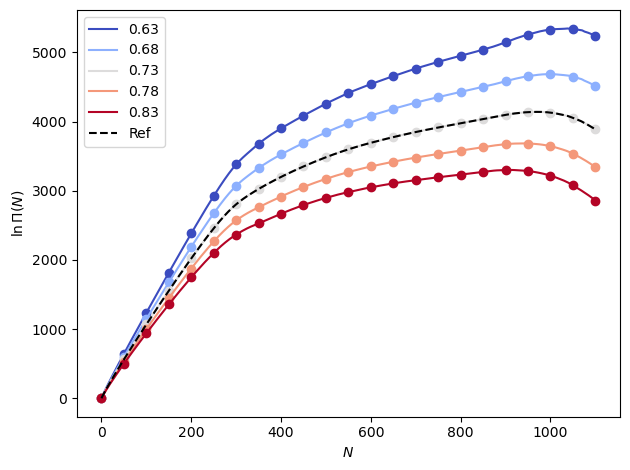

In [25]:
#Plot the results
fig, ax = plt.subplots()

colors = plt.cm.coolwarm(np.linspace(0.0, 1.0, len(betas)))

n_vals = np.arange(out_lnpi.sizes['n'])

for i, b in enumerate(betas):
    ax.plot(n_vals, out_lnpi.sel(beta=b), color=colors[i], label='%1.2f'%temps[i])
    ax.plot(n_vals[::50], samples[i]['lnPi'].values[::50], 'o', color=colors[i])
    
ax.plot(n_vals, ref['lnPi'], 'k--', label='Ref')

ax.set_xlabel(r'$N$')
ax.set_ylabel('$\ln \Pi (N)$')

ax.legend()

fig.tight_layout()

plt.show()